In [2]:
#load libs
library(ggplot2)
library(gridExtra)
library(cowplot)
theme_set(theme_cowplot())
library(fitdistrplus)
library(readr)
library(tibble)
library(dplyr)
library(ANOVAreplication)
library(svglite)
library(reshape2)
library(pwr)
print("loaded")

[1] "loaded"


In [4]:
#read in data and split the probands from sibs
sv_info=read.csv("../data/dnsv_dataframe.csv", header=TRUE, sep=",")
sv_info$status = recode(sv_info$role, "sib"="Unaffected","proband"="Probands", "mother"="Unaffected","father"="Unaffected")

sv_info = sv_info[(sv_info$father != ".") & (sv_info$mother != ".") ,]
sv_info = sv_info[(sv_info$father_age_birth_years >0) & (sv_info$mother_age_birth_years >0),]
sv_info$father_age_birth_years = as.integer(sv_info$father_age_birth_years)
sv_info$mother_age_birth_years = as.integer(sv_info$mother_age_birth_years)
sv_info$has_dnSV = factor(sv_info$all_sv > 0)
sv_info$dnSV = factor(sv_info$all_sv>0)
dad_sv_info = sv_info[(sv_info$paternal == 1) | (sv_info$dnSV == FALSE) ,]
mom_sv_info = sv_info[(sv_info$maternal == 1) | (sv_info$dnSV == FALSE) ,]

#size data
size_freqs=read.csv("../data/size_freqs.csv", header=TRUE, sep=",")
size_freqs$Proband = size_freqs$Proband.rate
size_freqs$Sibling = size_freqs$Sibling.rate
options(scipen = 999)

print("data ready")

sv_info

[1] "data ready"


,X,dn_snvs,father,father_age_birth_years,mother,mother_age_birth_years,project,role,sex,DEL,⋯,MEI,CPX,CTX,INV,all_sv,paternal,maternal,status,has_dnSV,dnSV
,<int>,<int>,<fct>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>
3,2,79,0000,36,0001,35,SFARI,proband,male,0,⋯,0,0,0,0,0,0,0,Probands,FALSE,FALSE
4,3,46,0000,29,0001,27,SFARI,sib,female,1,⋯,0,0,0,0,1,0,0,Unaffected,TRUE,TRUE
7,6,0,0004,32,0005,29,SFARI,proband,male,0,⋯,0,0,0,0,0,0,0,Probands,FALSE,FALSE
10,9,92,0007,43,0008,42,SFARI,proband,female,0,⋯,0,0,0,0,0,0,0,Probands,FALSE,FALSE
11,10,82,0007,40,0008,39,SFARI,sib,male,0,⋯,0,0,0,0,0,0,0,Unaffected,FALSE,FALSE
14,13,94,0011,42,0012,37,SFARI,proband,male,0,⋯,0,0,0,0,0,0,0,Probands,FALSE,FALSE
15,14,93,0011,46,0012,42,SFARI,sib,female,0,⋯,0,0,0,0,0,0,0,Unaffected,FALSE,FALSE
18,17,68,0015,32,0016,29,SFARI,proband,male,2,⋯,0,0,0,0,2,1,0,Probands,TRUE,TRUE
19,18,89,0015,37,0016,35,SFARI,sib,male,0,⋯,0,0,0,0,0,0,0,Unaffected,FALSE,FALSE


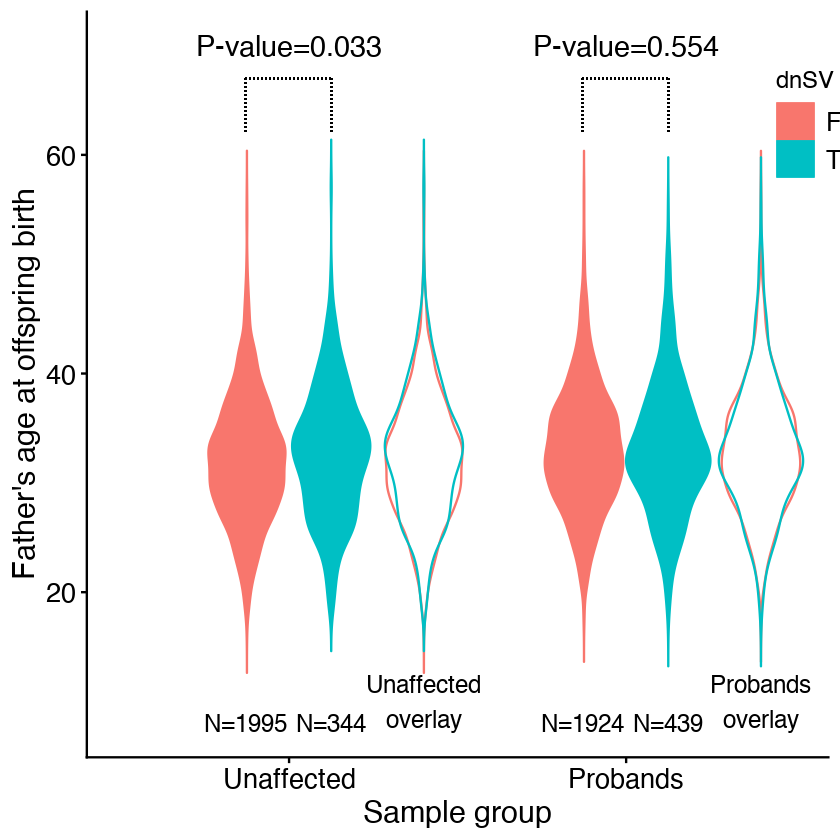

In [4]:
#Figure 3: Age comparison by wilcoxon test
####################################################################################################
#"greater" tests whether X(has dnSV) is right-shifted vs y (doesn't have dnSV)
sib_test_stat_age = wilcox.test(alternative="greater",
  sv_info$father_age_birth_years[(sv_info$dnSV == TRUE) & (sv_info$status == "Unaffected") ], 
  sv_info$father_age_birth_years[(sv_info$dnSV == FALSE) & (sv_info$status == "Unaffected")]
)
#"greater" tests whether X(has dnSV) is right-shifted vs y (doesn't have dnSV)
proband_test_stat_age = wilcox.test(alternative="greater",
  sv_info$father_age_birth_years[(sv_info$dnSV == TRUE) & (sv_info$status == "Probands") ], 
  sv_info$father_age_birth_years[(sv_info$dnSV == FALSE) & (sv_info$status == "Probands")]
)

lengths=c(
  length(sv_info$dnSV[(sv_info$status == "Unaffected") & (sv_info$dnSV == FALSE)]),
  length(sv_info$dnSV[(sv_info$status == "Unaffected") & (sv_info$dnSV == TRUE)]),
  length(sv_info$dnSV[(sv_info$status == "Probands") & (sv_info$dnSV == FALSE)]),
  length(sv_info$dnSV[(sv_info$status == "Probands") & (sv_info$dnSV == TRUE)])
)

ggplot(sv_info[sv_info$status != "NA",], aes(
  x=status,
  y=father_age_birth_years, 
  color=dnSV,
  fill=dnSV
)) + 
  theme_cowplot() +
  # geom_violin(trim=FALSE, width=.6, position = position_dodge(1.2)) + 
  # geom_violin(trim=FALSE, width = .3, position = position_identity(), alpha=0, color = NA)+
  # geom_violin(trim=FALSE, width = .3, position = position_identity(), alpha=0)+
  geom_violin(trim=FALSE, width=.5) + 
  geom_violin(trim=FALSE, width = .25, position = position_nudge(0.4), alpha=0)+
  labs(y= "Father's age at offspring birth", x = "Sample group")+
  annotate("text", x=.87, y=8, label = paste("N=",lengths[1], sep=""), size=5) +
  annotate("text", x=1.125, y=8, label = paste("N=",lengths[2], sep=""), size=5) +
  annotate("text", x=1.4, y=10, label = paste("Unaffected\noverlay", sep=""), size=5) +
  annotate("text", x=1.87, y=8, label = paste("N=",lengths[3], sep=""), size=5) +
  annotate("text", x=2.125, y=8, label = paste("N=",lengths[4], sep=""), size=5) +
  annotate("text", x=2.4, y=10, label = paste("Probands\noverlay", sep=""), size=5) +
  annotate("text", x=1, y=70, label = paste("P-value=",round(sib_test_stat_age$p.value,3), sep=""), size=6)+
  annotate("text", x=2, y=70, label = paste("P-value=",round(proband_test_stat_age$p.value,3), sep=""), size=6) +
  
  geom_segment(aes(x=.87, y=67, xend=1.125, yend=67),linetype='dotted',color='black') +
  geom_segment(aes(x=.87, y=67, xend=.87, yend=62),linetype='dotted',color='black') +
  geom_segment(aes(x=1.125, y=67, xend=1.125, yend=62),linetype='dotted',color='black') +
  geom_segment(aes(x=1.87, y=67, xend=2.125, yend=67),linetype='dotted',color='black') +
  geom_segment(aes(x=1.87, y=67, xend=1.87, yend=62),linetype='dotted',color='black') +
  geom_segment(aes(x=2.125, y=67, xend=2.125, yend=62),linetype='dotted',color='black') +
  theme(
    legend.position=c(0.93,0.85),
    legend.key.size = unit(.8, "cm"),
    legend.text = element_text(size=15),
    axis.text =  element_text(size=16),
    axis.title =  element_text(size=18)
  )
ggsave("../plots/fig3.png", width = 10, height = 5, dpi=200)

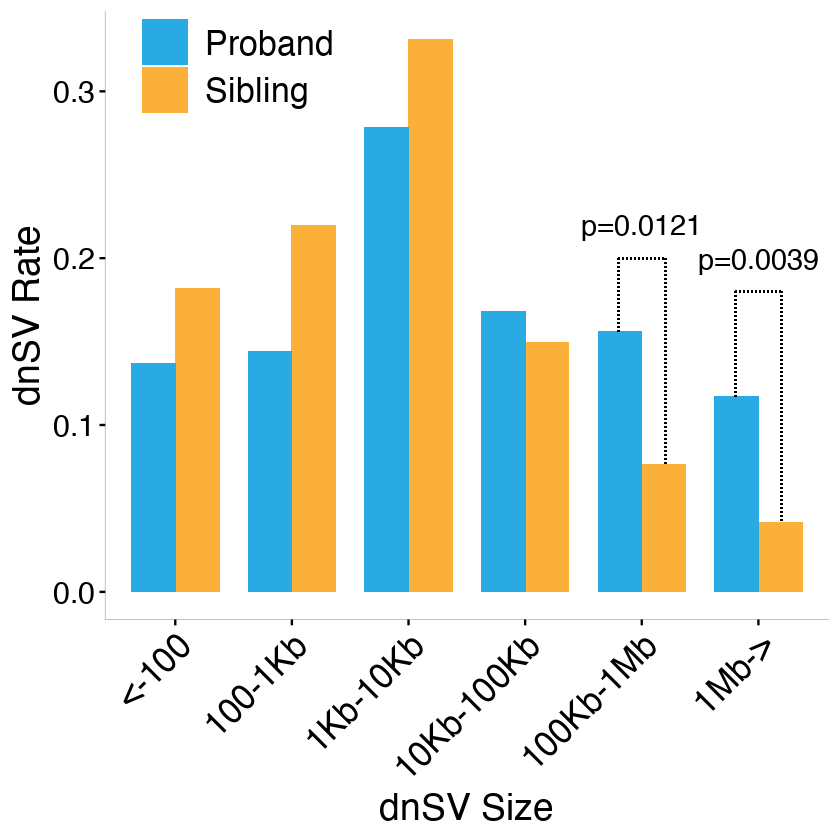

In [5]:
#Figure 4B: Size vs ASD status
####################################################################################################
size_freqs.m = melt(size_freqs[,c('Sizes', "Proband", "Sibling")], id.vars='Sizes')
size_freqs.m$ordered_sizes = factor(size_freqs.m$Sizes[1:6], levels = size_freqs.m$Sizes[1:6],ordered=TRUE)

proband_marker1=size_freqs.m$value[((size_freqs.m$Sizes=="100Kb-1Mb") & (size_freqs.m$variable=="Proband"))]
sib_marker1=size_freqs.m$value[((size_freqs.m$Sizes=="100Kb-1Mb") & (size_freqs.m$variable=="Sibling"))]

proband_marker2=size_freqs.m$value[((size_freqs.m$Sizes=="1Mb->") & (size_freqs.m$variable=="Proband"))]
sib_marker2=size_freqs.m$value[((size_freqs.m$Sizes=="1Mb->") & (size_freqs.m$variable=="Sibling"))]

ggplot(data=size_freqs.m, aes(x=ordered_sizes, y=value, fill=variable)) +
  geom_col(width=.75, position=position_dodge())+
  labs(y= "dnSV Rate", x = "dnSV Size") +
  scale_fill_manual(values=c("#29AAE2", "#FBB03A"), name="") +
  
  geom_segment(aes(x=4.8, y=0.2, xend=5.2, yend=0.2),linetype='dotted',color='black') +
  geom_segment(aes(x=4.8, y=0.2, xend=4.8, yend=proband_marker1),linetype='dotted',color='black') +
  geom_segment(aes(x=5.2, y=0.2, xend=5.2, yend=sib_marker1),linetype='dotted',color='black') +
  annotate("text", x=5, y=0.22, size=6, label = paste("p=",round(size_freqs$padj[5],4), sep="")) +
  
  geom_segment(aes(x=5.8, y=0.18, xend=6.2, yend=0.18),linetype='dotted',color='black') +
  geom_segment(aes(x=5.8, y=0.18, xend=5.8, yend=proband_marker2),linetype='dotted',color='black') +
  geom_segment(aes(x=6.2, y=0.18, xend=6.2, yend=sib_marker2),linetype='dotted',color='black') +
  annotate("text", x=6, y=0.20, size=6, label = paste("p=",round(size_freqs$padj[6],4), sep="")) +
  theme_cowplot()+
  theme(
      text = element_text(size=20),
      axis.text.x = element_text(angle = 45, hjust = 1,size=20),
      axis.text.y = element_text(size=18),
      legend.position=c(0.05,0.95),
      legend.key.size = unit(1, "cm"),
      legend.text = element_text(size=20),
      axis.line=element_line(size=.2, color="grey"),
      axis.title = element_text(size=22)
    )
ggsave("../plots/fig4B.png", dpi=200, width = 10, height = 5)

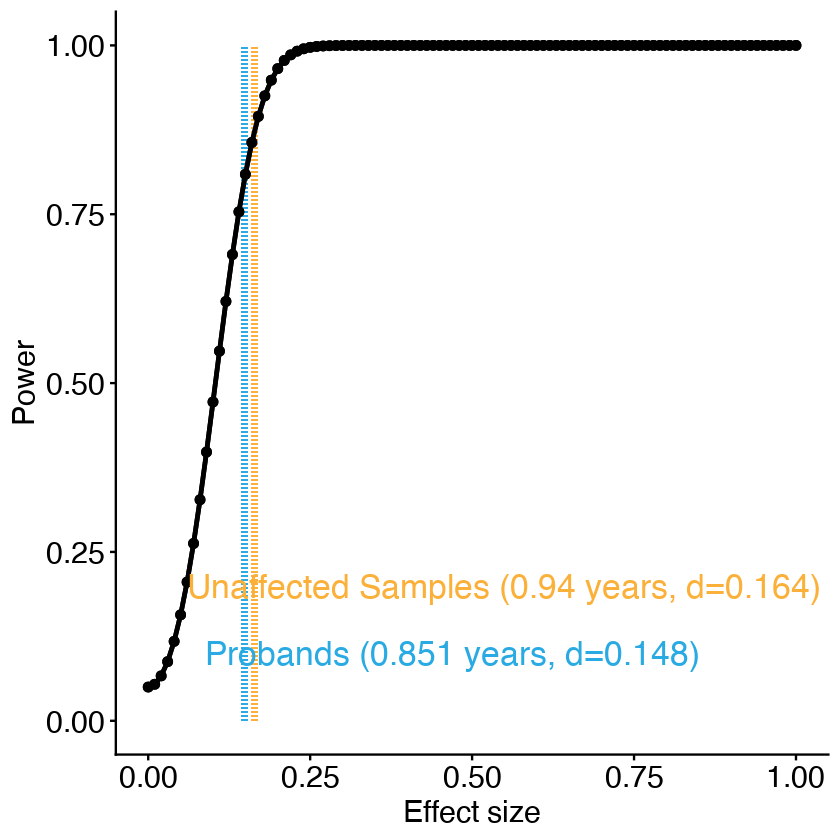

In [6]:
#Supplemental Figure 3: Power analysis
####################################################################################################
powers = c()
effect_sizes = c()
for (i in seq(0,1, by=0.01)){
  pwr_test = (pwr.t2n.test(n1=lengths[1],n2=lengths[2],d=i,sig.level=0.05))
  powers = append(powers, pwr_test$power)
  effect_sizes=append(effect_sizes,i)
}

powers = c()
effect_sizes = c()
for (i in seq(0,1, by=0.01)){
  pwr_test = (pwr.t2n.test(n1=lengths[3],n2=lengths[4],d=i,sig.level=0.05))
  powers = append(powers, pwr_test$power)
  effect_sizes=append(effect_sizes,i)
}

sib_power_analysis = data.frame("Power"=powers,"Effect.size"=effect_sizes)
sibling_ef = pwr.t2n.test(n1=lengths[1],n2=lengths[2],power=0.8,sig.level=0.05)$d
proband_power_analysis = data.frame("Power"=powers,"Effect.size"=effect_sizes)
proband_ef = pwr.t2n.test(n1=lengths[3],n2=lengths[4],power=0.8,sig.level=0.05)$d

pooled_sd = pooled.sd(data.frame(ages=sv_info$father_age_birth_years, group=sv_info$has_dnSV))
sibs_ef_years = round(pooled_sd*sibling_ef,3)
probands_ef_years = round(pooled_sd*proband_ef,3)

ggplot(proband_power_analysis, aes(x=Effect.size, y=Power))+
  geom_segment(aes(x=proband_ef, y=0, xend=proband_ef, yend=1),color='#29AAE2',linetype="dotted", size=1.2)+
  geom_segment(aes(x=sibling_ef, y=0, xend=sibling_ef, yend=1),color='#FBB03A',linetype="dotted", size=1.2)+
  geom_line(color="black", size=1) +
  geom_point(color="black", size=2)+
  geom_line(data=sib_power_analysis,color="black",aes(x=Effect.size, y=Power),size=1)+
  geom_point(data=sib_power_analysis,color="black", aes(x=Effect.size, y=Power),size=2) +
  labs(y= "Power", x = "Effect size", fontsize=16)+#, title="Power analysis of father's age effect on dnSV risk")+
  annotate("text", x = .55, y = (.20), size=7, label = paste('Unaffected Samples (',sibs_ef_years,' years, d=',round(sibling_ef,3),')',sep=""), colour="#FBB03A") +
  annotate("text", x = .47, y = (.10), size=7, label = paste('Probands (',probands_ef_years,' years, d=',round(proband_ef,3),')',sep=""), colour="#29AAE2")+
  theme_cowplot() +
  theme(axis.text=element_text(size=18),axis.title=element_text(size=18))
  
ggsave("../plots/supp-fig3.png", dpi=250, width=10, height=5)

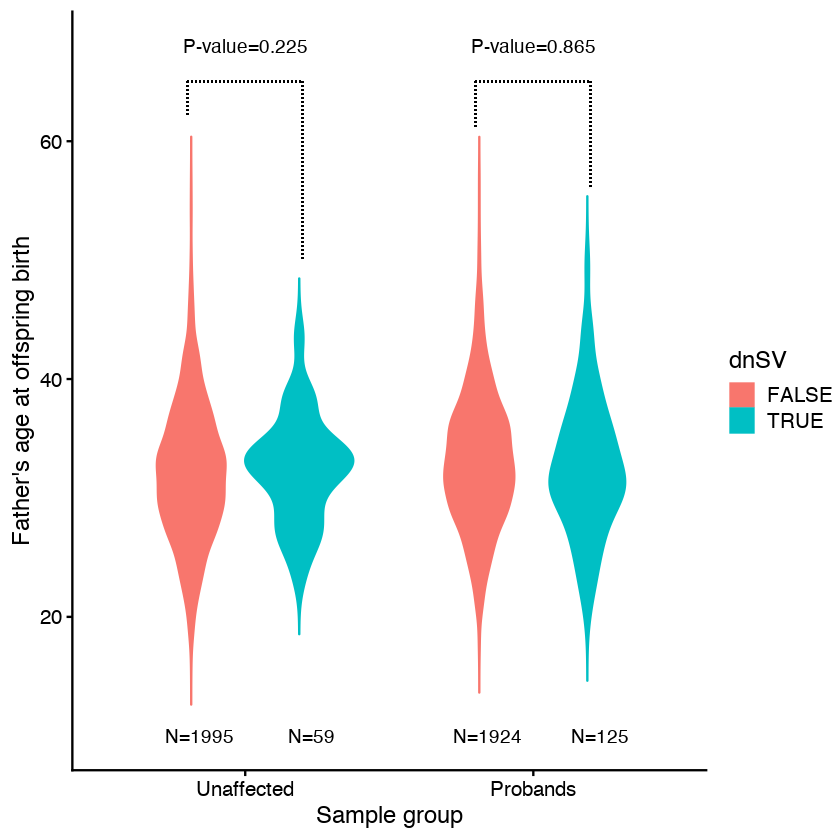

In [7]:
#Supplemental Figure 4A: Phased dnSV rate vs paternal age
####################################################################################################
#Mann-Whitney-Wilcoxon for count data.
dad_sib_test_stat_age = wilcox.test(alternative="greater",
  dad_sv_info$father_age_birth_years[(dad_sv_info$dnSV == TRUE) & (dad_sv_info$status == "Unaffected") ], 
  dad_sv_info$father_age_birth_years[(dad_sv_info$dnSV == FALSE) & (dad_sv_info$status == "Unaffected")]
)
dad_proband_test_stat_age = wilcox.test(alternative="greater",
  dad_sv_info$father_age_birth_years[(dad_sv_info$dnSV == TRUE) & (dad_sv_info$status == "Probands") ], 
  dad_sv_info$father_age_birth_years[(dad_sv_info$dnSV == FALSE) & (dad_sv_info$status == "Probands")]
)

dad_lengths=c(
  length(dad_sv_info$dnSV[(dad_sv_info$status == "Unaffected") & (dad_sv_info$dnSV == FALSE)]),
  length(dad_sv_info$dnSV[(dad_sv_info$status == "Unaffected") & (dad_sv_info$dnSV == TRUE)]),
  length(dad_sv_info$dnSV[(dad_sv_info$status == "Probands") & (dad_sv_info$dnSV == FALSE)]),
  length(dad_sv_info$dnSV[(dad_sv_info$status == "Probands") & (dad_sv_info$dnSV == TRUE)])
)
p = ggplot(dad_sv_info[dad_sv_info$status != "NA",], aes(
  x=status,
  y=father_age_birth_years, 
  color=dnSV,fill=dnSV
)) + 
  geom_violin(trim=FALSE,width=.75 ) + 
  labs(y= "Father's age at offspring birth", x = "Sample group")+#, title="Comparison of father's ages between samples with/without paternal dnSVs") +
  annotate("text", x=.84, y=10, label = paste("N=",dad_lengths[1], sep="")) +
  annotate("text", x=1.23, y=10, label = paste("N=",dad_lengths[2], sep="")) +
  annotate("text", x=1.84, y=10, label = paste("N=",dad_lengths[3], sep="")) +
  annotate("text", x=2.23, y=10, label = paste("N=",dad_lengths[4], sep="")) +
  annotate("text", x=1, y=68, label = paste("P-value=",round(dad_sib_test_stat_age$p.value,3), sep=""))+
  annotate("text", x=2, y=68, label = paste("P-value=",round(dad_proband_test_stat_age$p.value,3), sep=""))+
  theme_cowplot()

p = p + geom_segment(aes(x=.8, y=65, xend=1.2, yend=65),linetype='dotted',color='black')
p = p + geom_segment(aes(x=.8, y=65, xend=.8, yend=62),linetype='dotted',color='black')
p = p + geom_segment(aes(x=1.2, y=65, xend=1.2, yend=50),linetype='dotted',color='black')

p = p + geom_segment(aes(x=1.8, y=65, xend=2.2, yend=65),linetype='dotted',color='black')
p = p + geom_segment(aes(x=1.8, y=65, xend=1.8, yend=61),linetype='dotted',color='black')
p = p + geom_segment(aes(x=2.2, y=65, xend=2.2, yend=56),linetype='dotted',color='black')

p
ggsave("../plots/supp-fig4A.png", width = 9, height = 4, dpi=200)

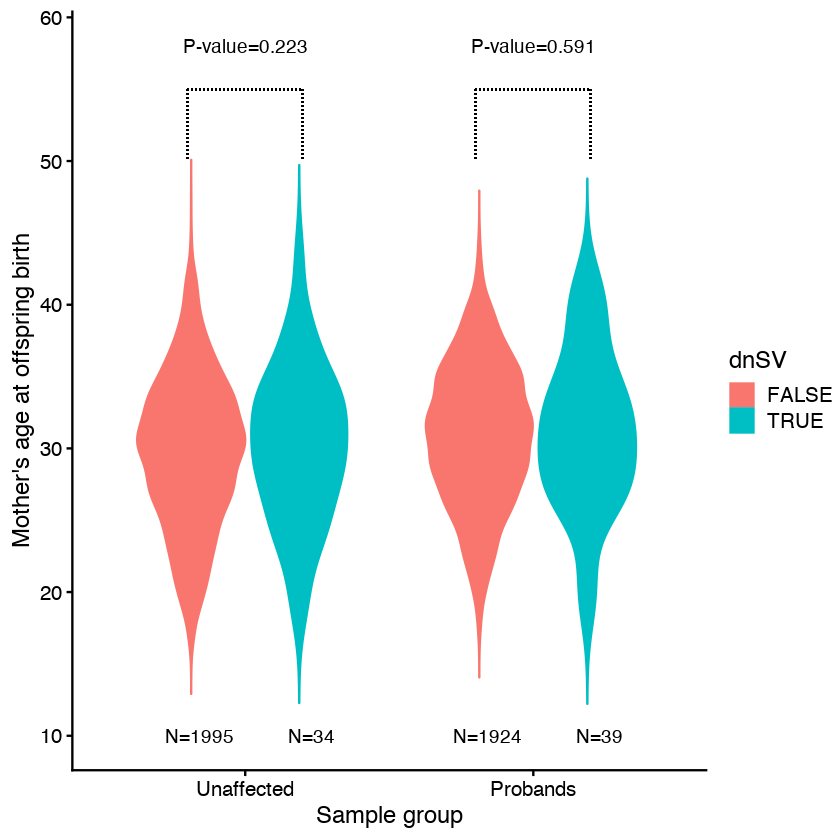

In [8]:
#Supplemental Figure 4B: Phased dnSV rate vs maternal age
####################################################################################################
#Mann-Whitney-Wilcoxon for count data.
mom_sib_test_stat_age = wilcox.test(alternative="greater",
  mom_sv_info$father_age_birth_years[(mom_sv_info$dnSV == TRUE) & (mom_sv_info$status == "Unaffected") ], 
  mom_sv_info$father_age_birth_years[(mom_sv_info$dnSV == FALSE) & (mom_sv_info$status == "Unaffected")]
)
mom_proband_test_stat_age = wilcox.test(alternative="greater",
  mom_sv_info$father_age_birth_years[(mom_sv_info$dnSV == TRUE) & (mom_sv_info$status == "Probands") ], 
  mom_sv_info$father_age_birth_years[(mom_sv_info$dnSV == FALSE) & (mom_sv_info$status == "Probands")]
)

mom_lengths=c(
  length(mom_sv_info$dnSV[(mom_sv_info$status == "Unaffected") & (mom_sv_info$dnSV == FALSE)]),
  length(mom_sv_info$dnSV[(mom_sv_info$status == "Unaffected") & (mom_sv_info$dnSV == TRUE)]),
  length(mom_sv_info$dnSV[(mom_sv_info$status == "Probands") & (mom_sv_info$dnSV == FALSE)]),
  length(mom_sv_info$dnSV[(mom_sv_info$status == "Probands") & (mom_sv_info$dnSV == TRUE)])
)
p = ggplot(mom_sv_info[mom_sv_info$status != "NA",], aes(
  x=status,
  y=mother_age_birth_years, 
  color=dnSV,fill=dnSV
)) + 
  geom_violin(trim=FALSE,width=.75 ) + 
  labs(y= "Mother's age at offspring birth", x = "Sample group")+
  annotate("text", x=.84, y=10, label = paste("N=",mom_lengths[1], sep="")) +
  annotate("text", x=1.23, y=10, label = paste("N=",mom_lengths[2], sep="")) +
  annotate("text", x=1.84, y=10, label = paste("N=",mom_lengths[3], sep="")) +
  annotate("text", x=2.23, y=10, label = paste("N=",mom_lengths[4], sep="")) +
  annotate("text", x=1, y=58, label = paste("P-value=",round(mom_sib_test_stat_age$p.value,3), sep=""))+
  annotate("text", x=2, y=58, label = paste("P-value=",round(mom_proband_test_stat_age$p.value,3), sep=""))+
  theme_cowplot()

p = p + geom_segment(aes(x=.8, y=55, xend=1.2, yend=55),linetype='dotted',color='black')
p = p + geom_segment(aes(x=.8, y=55, xend=.8, yend=50),linetype='dotted',color='black')
p = p + geom_segment(aes(x=1.2, y=55, xend=1.2, yend=50),linetype='dotted',color='black')

p = p + geom_segment(aes(x=1.8, y=55, xend=2.2, yend=55),linetype='dotted',color='black')
p = p + geom_segment(aes(x=1.8, y=55, xend=1.8, yend=50),linetype='dotted',color='black')
p = p + geom_segment(aes(x=2.2, y=55, xend=2.2, yend=50),linetype='dotted',color='black')

p
ggsave("../plots/supp-fig4B.png", width = 9, height = 4, dpi=200)

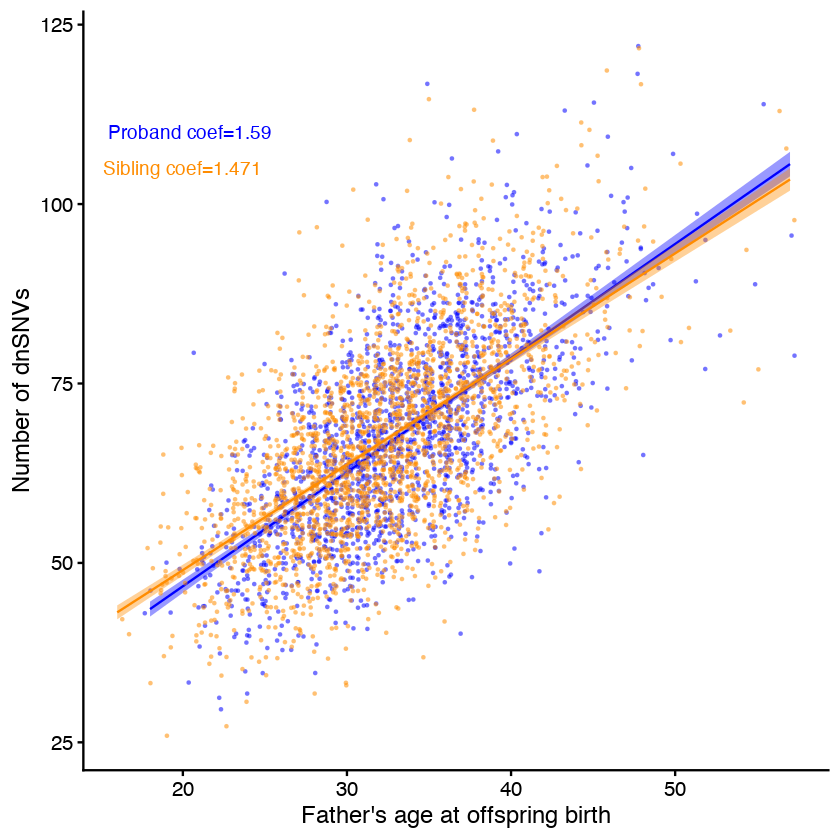

In [9]:
#Supplemental Figure 5: dnSNV counts vs paternal age
####################################################################################################
adjust_ar=FALSE
alpha=.4
proband_snv_info = sv_info[(!is.na(sv_info$dn_snvs)) &(sv_info$dn_snvs>0) &(sv_info$dn_snvs<125) & (sv_info$status=='Probands'),]
proband_model = glm(dn_snvs ~ father_age_birth_years, data=proband_snv_info, family = poisson(link="identity"))
proband_pred = predict(proband_model, type='response', se.fit=TRUE)
#CIs
dist=1.96
proband_snv_info$dad_ci_lo = proband_pred$fit - dist * proband_pred$se.fit
proband_snv_info$dad_ci_hi = proband_pred$fit + dist * proband_pred$se.fit

sib_snv_info = sv_info[(!is.na(sv_info$dn_snvs)) & (sv_info$dn_snvs>0) &(sv_info$dn_snvs<125) & (sv_info$status=='Unaffected'),]
sib_model = glm(dn_snvs ~ father_age_birth_years, data=sib_snv_info, family = poisson(link="identity"))
sib_pred = predict(sib_model, type='response', se.fit=TRUE)
#CIs
dist=1.96
sib_snv_info$dad_ci_lo = sib_pred$fit - dist * sib_pred$se.fit
sib_snv_info$dad_ci_hi = sib_pred$fit + dist * sib_pred$se.fit

# get min and max X and Y values for plot limits
min_age = min(min(sib_snv_info$father_age_birth_years), min(proband_snv_info$father_age_birth_years))
max_age = max(max(sib_snv_info$father_age_birth_years), max(proband_snv_info$father_age_birth_years))
min_dnm = min(min(sib_snv_info$dn_snvs),min(proband_snv_info$dn_snvs))
max_dnm = max(max(sib_snv_info$dn_snvs),max(proband_snv_info$dn_snvs))


# set the upper Y limit 
if (max_dnm < 15) {
  max_dnm = max_dnm
} else {
  max_dnm = max_dnm + 15
}

# adjust the aspect ratio if needed.
# these adjustments are specific to plotting either second-generation
# DNMs or gonosomal DNMs, and are for aesthetic purposes only
if (adjust_ar) {
  adjust = (0.075 * min_age/min_dnm)
}else {
  adjust = 2.25
}

proband_color = "blue"
sib_color = "darkorange"

ggplot(proband_snv_info[proband_snv_info$dn_snvs > 0,]) + 
  # plot the raw data - probands
  geom_jitter(data=proband_snv_info, aes(x=father_age_birth_years, y=dn_snvs, alpha=0.8),size=1, pch=21, fill=proband_color, col='white', stroke=0.05, show.legend = FALSE) +
  # plot the predictions from the fitted GLM - probands
  geom_line(data=cbind(proband_snv_info, pred_d=proband_pred$fit), aes(x=father_age_birth_years, y=pred_d), col=proband_color) +
  # plot confidence bands - probands
  geom_ribbon(data=proband_snv_info,aes(x=father_age_birth_years, ymin=dad_ci_lo, ymax=dad_ci_hi), alpha=alpha, fill=proband_color, show.legend = FALSE) +
  # plot the raw data - sibs
  geom_jitter(data=sib_snv_info, aes(x=father_age_birth_years, y=dn_snvs, alpha=0.8), size=1, pch=21, fill=sib_color, col='white', stroke=0.05, show.legend = FALSE) +
  # plot the predictions from the fitted GLM - sibs
  geom_line(data=cbind(sib_snv_info, pred_d=sib_pred$fit), aes(x=father_age_birth_years, y=pred_d), col=sib_color) +
  # plot confidence bands - sibs
  geom_ribbon(data=sib_snv_info, aes(x=father_age_birth_years, ymin=dad_ci_lo, ymax=dad_ci_hi), alpha=alpha, fill=sib_color, show.legend = FALSE) +
  theme_cowplot()+
  annotate("text", x=20.45, y=110, label = paste("Proband coef=",round(coef(proband_model)[2], digits=3), sep=""), color=proband_color) +
  annotate("text", x=20, y=105, label = paste("Sibling coef=",round(coef(sib_model)[2], digits=3), sep=""), color=sib_color) +
  labs(x= "Father's age at offspring birth", y = "Number of dnSNVs")+#, title="Correlation between paternal age and dnSNV count ") 
ggsave("../plots/supp-fig5.png", width = 8, height = 4, dpi=200)

In [10]:
#Supplemental figure 6
####################################################################################################
#dn SNV comparison
#Mann-Whitney-Wilcoxon for count data with different group sizes
snv_sv_info = sv_info[(sv_info$father_age_birth_years > 0) & (sv_info$dn_snvs > 0),]

sib_snv_test_stat_dnsnv = wilcox.test(alternative="greater",
  as.numeric(snv_sv_info$dn_snvs[(snv_sv_info$dnSV == TRUE) & (snv_sv_info$status == "Unaffected")]),
  as.numeric(snv_sv_info$dn_snvs[(snv_sv_info$dnSV == FALSE) & (snv_sv_info$status == "Unaffected")]),
)

proband_snv_test_stat_dnsnv = wilcox.test(alternative="greater",
  as.numeric(snv_sv_info$dn_snvs[(snv_sv_info$dnSV == TRUE) & (snv_sv_info$status == "Probands")]),
  as.numeric(snv_sv_info$dn_snvs[(snv_sv_info$dnSV == FALSE) & (snv_sv_info$status == "Probands")]),
)

lengths=c(
    length(snv_sv_info$dnSV[(snv_sv_info$status == "Unaffected") & (snv_sv_info$dnSV == FALSE) ]),
    length(snv_sv_info$dnSV[(snv_sv_info$status == "Unaffected") & (snv_sv_info$dnSV == TRUE) ]),
    length(snv_sv_info$dnSV[(snv_sv_info$status == "Probands") & (snv_sv_info$dnSV == FALSE) ]),
    length(snv_sv_info$dnSV[(snv_sv_info$status == "Probands") & (snv_sv_info$dnSV == TRUE) ])
)

p = ggplot(snv_sv_info, aes(
  x=status,
  y=dn_snvs,
  color=dnSV,
  fill=dnSV
)) +
  geom_violin(trim=FALSE,width=.75 ) +
  labs(y= "dnSNV count", x = "Sample group")+
  annotate("text", x=.84, y=0, label = paste("N=",lengths[1], sep="")) +
  annotate("text", x=1.23, y=0, label = paste("N=",lengths[2], sep="")) +
  annotate("text", x=1.84, y=0, label = paste("N=",lengths[3], sep="")) +
  annotate("text", x=2.23, y=0, label = paste("N=",lengths[4], sep="")) +
  annotate("text", x=1, y=260, label = paste("P-value=",round(sib_snv_test_stat_dnsnv$p.value,3), sep=""))+
  annotate("text", x=2, y=260, label = paste("P-value=",round(proband_snv_test_stat_dnsnv$p.value,3), sep=""))+
  theme_cowplot()

p = p + geom_segment(aes(x=.8, y=250, xend=1.2, yend=250),linetype='dotted',color='black')
p = p + geom_segment(aes(x=.8, y=250, xend=.8, yend=220),linetype='dotted',color='black')
p = p + geom_segment(aes(x=1.2, y=250, xend=1.2, yend=160),linetype='dotted',color='black')

p = p + geom_segment(aes(x=1.8, y=250, xend=2.2, yend=250),linetype='dotted',color='black')
p = p + geom_segment(aes(x=1.8, y=250, xend=1.8, yend=200),linetype='dotted',color='black')
p = p + geom_segment(aes(x=2.2, y=250, xend=2.2, yend=245),linetype='dotted',color='black')

p
ggsave("/Users/jon/Desktop/violins_dnsnv.svg", width = 8, height = 4, dpi=200)

[1] "done"


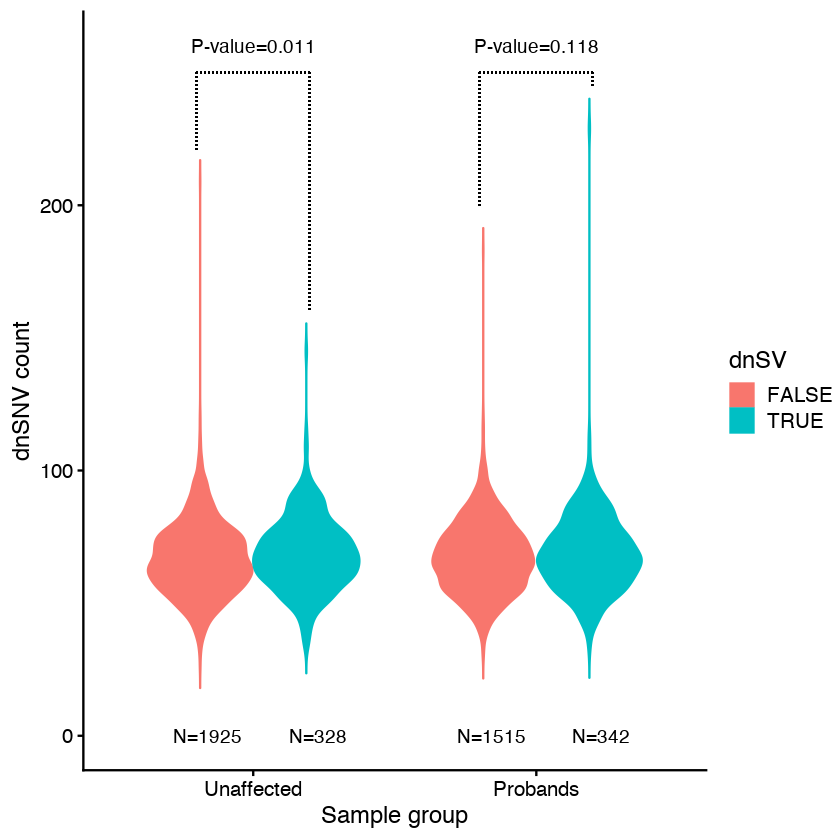

In [90]:
#Supplemental Figure 7: dnSV subtype age comparison by wilcoxon test
####################################################################################################
svtypes = c("MEI","DUP", "DEL")
for (i in 1:length(svtypes)) {
  svtype = svtypes[i]
  if (svtype == "MEI") {
    typed_sv_info = sv_info[(sv_info$MEI > 0) | (sv_info$dnSV == FALSE),]
  } else if (svtype == "DUP") {
    typed_sv_info = sv_info[(sv_info$DUP > 0) | (sv_info$dnSV == FALSE),]
  } else if (svtype == "DEL") {
    typed_sv_info = sv_info[(sv_info$DEL > 0) | (sv_info$dnSV == FALSE),]
  }
  
  sib_test_stat = wilcox.test(alternative="greater",
    typed_sv_info$father_age_birth_years[(typed_sv_info$dnSV == TRUE) & (typed_sv_info$status == "Unaffected") ], 
    typed_sv_info$father_age_birth_years[(typed_sv_info$dnSV == FALSE) & (typed_sv_info$status == "Unaffected")]
  )
  proband_test_stat = wilcox.test(alternative="greater",
    sv_info$father_age_birth_years[(typed_sv_info$dnSV == TRUE) & (typed_sv_info$status == "Probands") ], 
    sv_info$father_age_birth_years[(typed_sv_info$dnSV == FALSE) & (typed_sv_info$status == "Probands")]
  )
  lengths=c(
    length(typed_sv_info$dnSV[(typed_sv_info$status == "Unaffected") & (typed_sv_info$dnSV == FALSE)]),
    length(typed_sv_info$dnSV[(typed_sv_info$status == "Unaffected") & (typed_sv_info$dnSV == TRUE)]),
    length(typed_sv_info$dnSV[(typed_sv_info$status == "Probands") & (typed_sv_info$dnSV == FALSE)]),
    length(typed_sv_info$dnSV[(typed_sv_info$status == "Probands") & (typed_sv_info$dnSV == TRUE)])
  )
  p = ggplot(typed_sv_info[typed_sv_info$status != "NA",], aes(
    x=status,
    y=father_age_birth_years, 
    color=dnSV,fill=dnSV
  )) + 
    geom_violin(trim=FALSE,width=.75 ) + 
    labs(y= "Father's age at offspring birth", x = "Sample group") +
    annotate("text", x=.84, y=10, label = paste("N=",lengths[1], sep="")) +
    annotate("text", x=1.23, y=10, label = paste("N=",lengths[2], sep="")) +
    annotate("text", x=1.84, y=10, label = paste("N=",lengths[3], sep="")) +
    annotate("text", x=2.23, y=10, label = paste("N=",lengths[4], sep="")) +
    annotate("text", x=1, y=68, label = paste("P-value=",round(sib_test_stat$p.value,3), sep=""))+
    annotate("text", x=2, y=68, label = paste("P-value=",round(proband_test_stat$p.value,3), sep=""))+
    theme_cowplot()
  
  p = p + geom_segment(aes(x=.8, y=65, xend=1.2, yend=65),linetype='dotted',color='black')
  p = p + geom_segment(aes(x=.8, y=65, xend=.8, yend=60),linetype='dotted',color='black')
  p = p + geom_segment(aes(x=1.2, y=65, xend=1.2, yend=60),linetype='dotted',color='black')
  
  p = p + geom_segment(aes(x=1.8, y=65, xend=2.2, yend=65),linetype='dotted',color='black')
  p = p + geom_segment(aes(x=1.8, y=65, xend=1.8, yend=60),linetype='dotted',color='black')
  p = p + geom_segment(aes(x=2.2, y=65, xend=2.2, yend=60),linetype='dotted',color='black')
  
  p = p + scale_fill_manual(values=c("lightgrey", "black"))
  p = p + scale_color_manual(values=c("lightgrey", "black"))
  ggsave(paste("../plots/supp-fig6-",svtype,".png", sep=""), width = 8, height = 4, dpi=200)

}

print("done")